In [364]:
from ast import Dict, List, Tuple
import torch
from torch import nn
import matplotlib.pyplot as plt

In [365]:
#Data agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"We are now running on device : {device}")

We are now running on device : cuda


In [366]:
#Prepare the NN model for Polynomial
class PolynomialInfereceModelV0(nn.Module):
    def __init__(self,input_shape:int , hidden_units: int ,output_shape:int):
        super().__init__()
        self.A = nn.Parameter(torch.randn(1,requires_grad = True,dtype = torch.float32))
        self.B = nn.Parameter(torch.randn(1,requires_grad = True,dtype = torch.float32))
        self.C = nn.Parameter(torch.randn(1,requires_grad = True,dtype = torch.float32))

    def forward(self,x):
        return self.A * (x**2) + self.B * x + self.C

INPUT = 3
OUTPUT = 1
HIDDEN_UNITS = 10

model_0 = PolynomialInfereceModelV0(INPUT,HIDDEN_UNITS,OUTPUT).to(device)
print(model_0.state_dict())

#You had better read through the problem. what it really wants
#It has 3 parameters. A,B,C. So our test data is of A,B,C

OrderedDict([('A', tensor([-0.1871], device='cuda:0')), ('B', tensor([0.4339], device='cuda:0')), ('C', tensor([0.2572], device='cuda:0'))])


x_train_shape : torch.Size([900, 1]) y_train_shape: torch.Size([900, 1]) 
 x_test_shape: torch.Size([100, 1]) y_test_shape: torch.Size([100, 1])


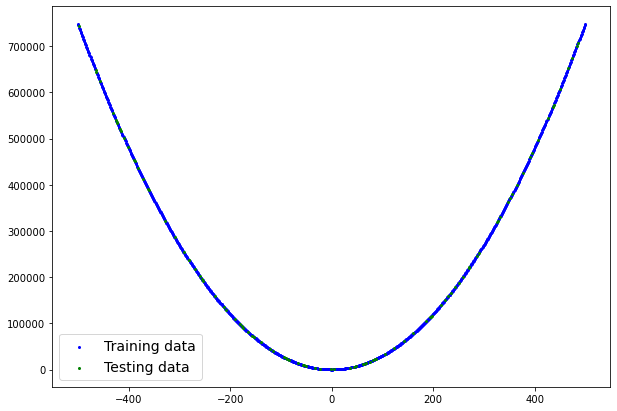

In [367]:
#Prepare the data set using train_split then visualize the data
import numpy as np
from sklearn.model_selection import train_test_split

def prepare_PolyData(second_order_term:int,first_order_term:int,constant:int,test_size:int):
    X = torch.arange(-500,500).unsqueeze(dim=1)
    y = second_order_term * pow(X,2) + first_order_term * X + constant

    return train_test_split(X,y,test_size = test_size,random_state = None)

def plot_predictions(train_data,
                     train_labels,
                     test_data,
                     test_labels,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});


SECOND_ORDER_TERM = 3
FIRST_ORDER_TERM = 2
CONSTANT = 1
TEST_SIZE = 0.1

x_train,x_test,y_train,y_test = prepare_PolyData(SECOND_ORDER_TERM,FIRST_ORDER_TERM,CONSTANT,TEST_SIZE)
print(f"x_train_shape : {x_train.shape} y_train_shape: {y_train.shape} \n x_test_shape: {x_test.shape} y_test_shape: {y_test.shape}")

plot_predictions(x_train,y_train,x_test,y_test,predictions = None)

#

In [368]:
#Build the function for training
from tqdm.auto import tqdm

NUM_EPOCHS = 20
LR = 1.1e-11
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),lr = LR)


#Creating empty loss to track values
train_loss_values = []
test_loss_values = []
epoch_count = []


x_train,x_test = x_train.type(torch.float32).to(device),x_test.type(torch.float32).to(device)
y_train,y_test = y_train.type(torch.float32).to(device),y_test.type(torch.float32).to(device)

for epoch in tqdm(range(NUM_EPOCHS)):
    model_0.train()
    y_pred = model_0(x_train) #<- forward pass
    loss   = loss_fn(y_pred,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #test
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(x_test)
        test_loss = loss_fn(test_pred,y_test)

     #Printing out what's happening also for visualization
    if epoch%2 == 0:
      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().to("cpu").numpy()) #<- must convert tensor back to numpy array to a
      test_loss_values.append(test_loss.detach().to("cpu").numpy())
      print(f'Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test loss: {test_loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | MAE Train Loss: 127127003136.0 | MAE Test loss: 65928806400.0
Epoch: 2 | MAE Train Loss: 35056852992.0 | MAE Test loss: 18179340288.0
Epoch: 4 | MAE Train Loss: 9667472384.0 | MAE Test loss: 5012560384.0
Epoch: 6 | MAE Train Loss: 2666063104.0 | MAE Test loss: 1382028032.0
Epoch: 8 | MAE Train Loss: 735344640.0 | MAE Test loss: 381052672.0
Epoch: 10 | MAE Train Loss: 202927648.0 | MAE Test loss: 105120272.0
Epoch: 12 | MAE Train Loss: 56107460.0 | MAE Test loss: 29079958.0
Epoch: 14 | MAE Train Loss: 15620080.0 | MAE Test loss: 8138104.0
Epoch: 16 | MAE Train Loss: 4455418.5 | MAE Test loss: 2377344.25
Epoch: 18 | MAE Train Loss: 1376574.0 | MAE Test loss: 796144.25


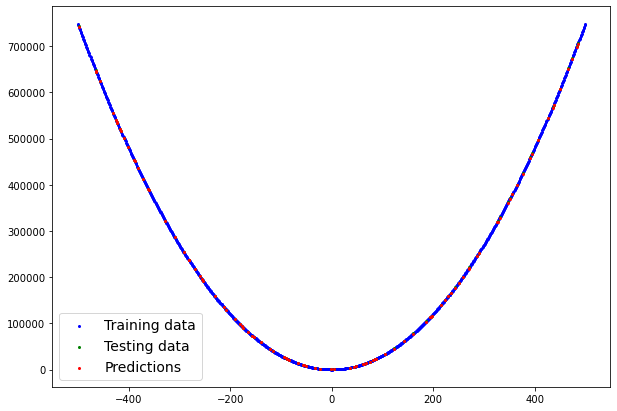

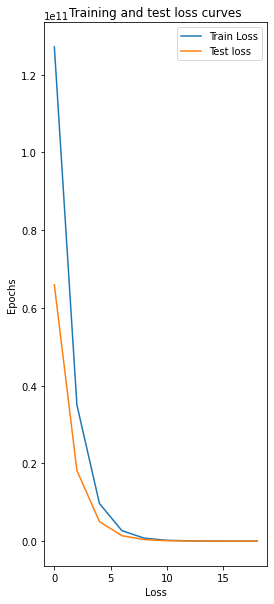

In [369]:
with torch.inference_mode():
    y_preds_new = model_0(x_test)
#Data get updated through back propagation and gradient descent
#Notice that after more training the predictions fits our testing data
plot_predictions(x_train.to("cpu"),y_train.to("cpu"),x_test.to("cpu"),y_test.to("cpu"),predictions = y_preds_new.to("cpu"))


#Plotting the train loss curves and test loss curves
plt.figure(figsize = (4,10))
plt.plot(epoch_count, train_loss_values, label = "Train Loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title("Training and test loss curves")
plt.xlabel("Loss")
plt.ylabel("Epochs")
plt.legend()